In [1]:
from google.colab import drive
from os.path import join
import os

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/Colab Notebooks/'       # path to your project on Drive



drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)


Mounted at /content/drive


In [ ]:
GIT_USERNAME = "ahhuang007" # replace with yours
GIT_TOKEN = os.environ['git_key_wsb']           # definitely replace with yours
GIT_REPOSITORY = "wallstreetbets"      # ...nah


In [ ]:
!mkdir "{PROJECT_PATH}"    # in case we haven't created it already   
%cd "{PROJECT_PATH}"

In [2]:
%cd drive/My Drive/Colab Notebooks/wallstreetbets

/content/drive/My Drive/Colab Notebooks/wallstreetbets


Pulling data from Github

In [30]:
!git pull origin

error: You have not concluded your merge (MERGE_HEAD exists).
hint: Please, commit your changes before merging.
fatal: Exiting because of unfinished merge.


Pushing updates to Github

In [47]:
!git add .

In [48]:
!git config --global user.email "ahhuang007@gmail.com"
!git config --global user.name "ahhuang007"

In [49]:
!git commit -m "did an sgdregressor, setting up simulation to test validation set"

[main 4d07510] did an sgdregressor, setting up simulation to test validation set
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite colab_ml_testing.ipynb (76%)


In [34]:
!git remote set-url origin https://$git_key_wsb@github.com/ahhuang007/wallstreetbets.git

In [50]:
!git push origin

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 63.53 KiB | 7.94 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/ahhuang007/wallstreetbets.git
   3e397b2..4d07510  main -> main


First approach - SGDRegressor

In [3]:
import pandas as pd

In [4]:
#Gathering data, formatting it for training/testing
from sklearn.preprocessing import MinMaxScaler

dfs = []
training_datas = []
cryptos = ['AAVE', 'ADA', 'ALGO', 'ATOM', 
           'AVAX', 'BCH', 'BTC', 'DOT', 
           'ETH', 'LINK', 'LRC', 'LTC', 
           'MANA', 'MATIC', 'SOL', 'UNI']
cryptos = ['BTC']
for c in cryptos:
    df = pd.read_csv('./data/' + c + '_data.csv')
    '''I think we'll do a similar plan to my source idea.
    5 months for training, 2 months for validation/tuning, 5 months for testing
    '''
    #dfs.append(df[38:175200].reset_index(drop = True))
    #Splitting data into training/validation/test
    
    df = df.drop(['timestamp', 'Unnamed: 0'], axis = 1)
    cols = df.columns
    df = df[38:]

    #Normalizing data
    scaler = MinMaxScaler()
    df = pd.DataFrame(data = scaler.fit_transform(df))
    df.columns = cols
    labels = df['close'][1:].reset_index(drop = True)
    training = (df[:175200].reset_index(drop = True), labels[:175200].reset_index(drop = True))
    validation = (df[175200:282600].reset_index(drop = True), labels[175200:282600].reset_index(drop = True))
    testing = (df[262800:-1].reset_index(drop = True), labels[262800:].reset_index(drop = True))
    training_datas.append([training, validation, testing])

In [26]:
#Import ML stuff, create gridsearch and fit
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

X_train = training_datas[0][0][0]
y_train = training_datas[0][0][1]
X_val = training_datas[0][1][0]
y_val = training_datas[0][1][1]
'''
param_grid = {'loss':('squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'),
              }
'''

sgdreg = SGDRegressor(max_iter = 1000, tol = 1e-4)
sgdreg.fit(X_train.values, y_train.values)

SGDRegressor(tol=0.0001)

In [28]:
sgdreg.score(X_val.values, y_val.values)

0.9999191574120494

In [30]:
preds = sgdreg.predict(X_val.values)

In [31]:
preds

array([0.69185847, 0.6928904 , 0.69310184, ..., 0.08989684, 0.08982791,
       0.08978288])

In [32]:
y_val

0         0.692990
1         0.693212
2         0.693435
3         0.693238
4         0.695084
            ...   
107395    0.089620
107396    0.089705
107397    0.089741
107398    0.089532
107399    0.089159
Name: close, Length: 107400, dtype: float64

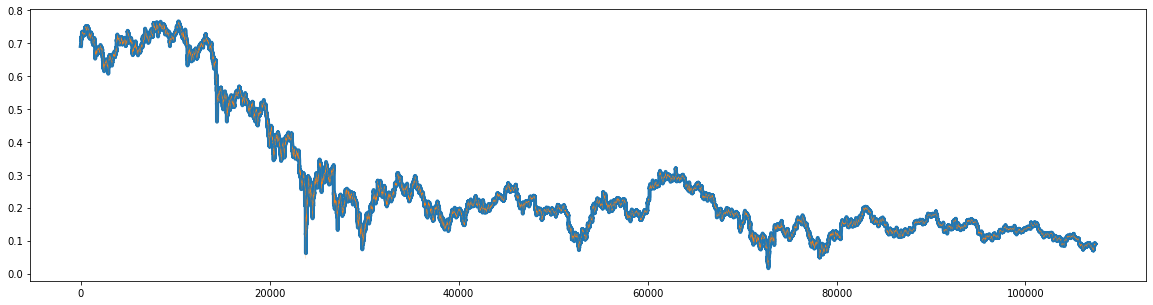

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)
fig = plt.figure()
plt.plot(preds, alpha = 1, linewidth = 4)
plt.plot(y_val, alpha = 1, linewidth = 0.1)
plt.show()

In [34]:
#naive approach - all-in trades with no fees
def sell_low(balance, shares, close):
    if shares > 0:
        #update balance
        balance += shares * close
        shares = 0
    else:
        pass #No shares to sell!
    return balance, shares

def buy_high(balance, shares, close):
    if balance > 0:
        #update balance
        shares += (balance / close)
        balance = 0
        
    else:
        pass
    return balance, shares

In [35]:
#Attempting simulation on validation data
import numpy as np

balance = 100
shares = 0
counter = 175200
orig_df = pd.read_csv('./data/BTC_data.csv')[175199:]
total = []
cur = orig_df.loc[175199, "close"]
for i in range(len(y_val)):
    if counter % 10000 == 0:
        print("Timestep {}: Balance is {}, shares is {}, total is {}".format(counter, balance, shares, total[-1]))
    pred = sgdreg.predict(np.array(X_val.loc[i,:]).reshape(1, 8))
    cur_norm = X_val.loc[i, 'close']
    #Figuring out which action to take
    if pred > cur_norm:
        balance, shares = buy_high(balance, shares, cur)
        #print("buying")
    elif pred < cur_norm:
        balance, shares = sell_low(balance, shares, cur)
        #print("selling")
    #time.sleep(3)
    total.append(balance + shares * cur)
    #Updating for next step
    counter += 1
    cur = orig_df.loc[counter, "close"]

Timestep 180000: Balance is 101.63667823777871, shares is 0, total is 101.63667823777871
Timestep 190000: Balance is 0, shares is 0.001878663145177423, total is 95.69015817876688
Timestep 200000: Balance is 70.4276643224571, shares is 0, total is 70.4276643224571
Timestep 210000: Balance is 0, shares is 0.0017668893951569811, total is 66.13375127824033
Timestep 220000: Balance is 0, shares is 0.0018670791828932403, total is 69.75310739171636
Timestep 230000: Balance is 0, shares is 0.00211191356107283, total is 78.60519043263902
Timestep 240000: Balance is 0, shares is 0.00220636014441749, total is 84.61172724186778
Timestep 250000: Balance is 80.81238076618119, shares is 0, total is 80.81238076618119
Timestep 260000: Balance is 0, shares is 0.0025292415099686092, total is 88.54057581392381
Timestep 270000: Balance is 95.40133002965779, shares is 0, total is 95.40133002965779
Timestep 280000: Balance is 0, shares is 0.0028092416940840425, total is 91.8344199961937


In [22]:
#Testing portion using final 5 months of data
import numpy as np

balance = 100
shares = 0
counter = 262800
orig_df = pd.read_csv('./data/BTC_data.csv')[262799:]
total = []
cur = orig_df.loc[262799, "close"]
for X, y in testing_loader:
    if counter % 10000 == 0:
        print("Timestep {}: Balance is {}, shares is {}, total is {}".format(counter, balance, shares, total[-1]))
    pred = model(X.float()).item()
    cur_norm = X[0][0][3].item()
    #Figuring out which action to take
    if pred > cur_norm:
        balance, shares = buy_high(balance, shares, cur)
        #print("buying")
    elif pred < cur_norm:
        balance, shares = sell_low(balance, shares, cur)
        #print("selling")
    #time.sleep(3)
    total.append(balance + shares * cur)
    #Updating for next step
    counter += 1
    cur = orig_df.loc[counter, "close"]

array([0.69192541])

Other possible approaches - SGDClassifier to test just increasing/decreasing classification, GridSearchCV on various methods, ensemble methods